In [1]:
import os
import sys
from tqdm.notebook import tqdm
import gc

import rasterio
from rasterio.windows import Window
import pandas as pd
import numpy as np
import cv2
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader 
import mmcv
sys.path.append('./mmsegmentation-src')
from mmseg.apis.inference import inference_segmentor, init_segmentor

import matplotlib.pyplot as plt

### Constants

In [2]:
CONFIG = '../configs/swin/upernet_swin_tiny_patch4_window7_512x512_20k_hubmap_256tile.py'
CHECKPOINT = '../work_dirs/upernet_swin_tiny_patch4_window7_512x512_20k_hubmap_256tile_resize_crop/latest.pth'
DATA = '../data/hubmap/train_images/'
df_sample = pd.read_csv('../data/hubmap/train.csv')

TILE_SIZE = 256
REDUCE_NUM = 4
device = 'cuda:5'

### Utils

##### rle_encoding

In [3]:
def rle_encode_less_memory(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    This simplified method requires first and last pixel to be zero
    '''
    pixels = img.T.flatten()
    
    # This simplified method requires first and last pixel to be zero
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] -= runs[::2]
    
    return ' '.join(str(x) for x in runs)

##### tile

In [4]:
def image2tile(im, size: int) -> list:
    w = h = size
    tiles = [im[i:(i + h), j:(j + w), ...] for i in range(0, im.shape[0], h) for j in range(0, im.shape[1], w)]
    idxs = [(i, (i + h), j, (j + w)) for i in range(0, im.shape[0], h) for j in range(0, im.shape[1], w)]
    for idx, tile in enumerate(tiles):
        if tile.shape[:2] != (h, w):
            tile_ = tile
            tile = np.zeros_like(tiles[0])
            tile[:tile_.shape[0], :tile_.shape[1], ...] = tile_
            tiles[idx] = tile
    return tiles, idxs


def tile2image(tiles, idxs, size: list):
    seg = np.zeros([*size, tiles[0].shape[2]], dtype=tiles[0].dtype)
    for tile, (i1, i2, j1, j2) in zip(tiles, idxs):
        i2 = min(i2, size[0])
        j2 = min(j2, size[1])
        seg[i1:i2, j1:j2, :] = tile[:(i2 - i1), :(j2 - j1), :]
    return seg

### Data

In [5]:
s_th = 40  #saturation blancking threshold
p_th = 1000*(TILE_SIZE//256)**2 #threshold for the minimum number of pixels
identity = rasterio.Affine(1, 0, 0, 0, 1, 0)

class TileDataset(Dataset):
    def __init__(self, idx, sz=TILE_SIZE, reduce_num=REDUCE_NUM):
        self.data = rasterio.open(os.path.join(DATA,idx+'.tiff'), transform = identity,
                                 num_threads='all_cpus')
        # some images have issues with their format 
        # and must be saved correctly before reading with rasterio
        if self.data.count != 3:
            subdatasets = self.data.subdatasets
            self.layers = []
            if len(subdatasets) > 0:
                for i, subdataset in enumerate(subdatasets, 0):
                    self.layers.append(rasterio.open(subdataset))
        self.shape = self.data.shape
        self.reduce_num = reduce_num
        self.sz = reduce_num*sz
        self.pad0 = (self.sz - self.shape[0]%self.sz)%self.sz
        self.pad1 = (self.sz - self.shape[1]%self.sz)%self.sz
        self.n0max = (self.shape[0] + self.pad0)//self.sz
        self.n1max = (self.shape[1] + self.pad1)//self.sz
        
    def __len__(self):
        return self.n0max*self.n1max
    
    def __getitem__(self, idx):
        # the code below may be a little bit difficult to understand,
        # but the thing it does is mapping the original image to
        # tiles created with adding padding, as done in
        # https://www.kaggle.com/iafoss/256x256-images ,
        # and then the tiles are loaded with rasterio
        # n0,n1 - are the x and y index of the tile (idx = n0*self.n1max + n1)
        n0,n1 = idx//self.n1max, idx%self.n1max
        # x0,y0 - are the coordinates of the lower left corner of the tile in the image
        # negative numbers correspond to padding (which must not be loaded)
        x0,y0 = -self.pad0//2 + n0*self.sz, -self.pad1//2 + n1*self.sz
        # make sure that the region to read is within the image
        p00,p01 = max(0,x0), min(x0+self.sz,self.shape[0])
        p10,p11 = max(0,y0), min(y0+self.sz,self.shape[1])
        img = np.zeros((self.sz,self.sz,3),np.uint8)
        # mapping the loade region to the tile
        if self.data.count == 3:
            img[(p00-x0):(p01-x0),(p10-y0):(p11-y0)] = np.moveaxis(self.data.read([1,2,3],
                window=Window.from_slices((p00,p01),(p10,p11))), 0, -1)
        else:
            for i,layer in enumerate(self.layers):
                img[(p00-x0):(p01-x0),(p10-y0):(p11-y0),i] =\
                  layer.read(1,window=Window.from_slices((p00,p01),(p10,p11)))
        
        if self.reduce_num != 1:
            img = cv2.resize(img,(self.sz//self.reduce_num,self.sz//self.reduce_num),
                             interpolation = cv2.INTER_AREA)
        #check for empty imges
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        h,s,v = cv2.split(hsv)
        if (s>s_th).sum() <= p_th or img.sum() <= p_th:
            #images with -1 will be skipped
            return cv2.cvtColor(img, cv2.COLOR_BGR2RGB), -1
        else: return cv2.cvtColor(img, cv2.COLOR_BGR2RGB), idx

### Model pred

In [6]:
#iterator like wrapper that returns predicted masks
class ModelPred:
    def __init__(self, model, dl):
        self.model = model
        self.dl = dl
        
    def __iter__(self):
        count=0
        for x,y in iter(self.dl):
            if ((y>=0).sum() > 0): #exclude empty images
                x = x[y>=0]
                y = y[y>=0]
                x_numpy = x[0].numpy()

                py = inference_segmentor(self.model, x_numpy)[0]
                py = torch.from_numpy(np.expand_dims(py, (0, 1))).float()
                py = F.upsample(py, scale_factor=REDUCE_NUM, mode="bilinear")
                py = py.permute(0,2,3,1).float()
                
                batch_size = len(py)
                for i in range(batch_size):
                    yield py[i],y[i]
                    count += 1
                    
    def __len__(self):
        return len(self.dl.dataset)

### Model

In [7]:
cfg = mmcv.Config.fromfile(CONFIG)
model = init_segmentor(cfg, CHECKPOINT, device=device)

/workspace/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


load checkpoint from local path: ../work_dirs/upernet_swin_tiny_patch4_window7_512x512_20k_hubmap_256tile_resize_crop/latest.pth


### Inference

In [8]:
names,preds = [],[]
imgs, pd_mks = [],[]
debug = True
for idx,row in tqdm(df_sample.iterrows(),total=len(df_sample)):
    idx = str(row['id'])
    ds = TileDataset(idx)
    #rasterio cannot be used with multiple workers
    dl = DataLoader(ds, 1, num_workers=0, shuffle=False, pin_memory=True)
    mp = ModelPred(model, dl)
    #generate masks
    mask = torch.zeros(len(ds),ds.sz,ds.sz,dtype=torch.int8)
    for p,i in iter(mp):
        mask[i.item()] = p.squeeze(-1)
    
    #reshape tiled masks into a single mask and crop padding
    mask = mask.view(ds.n0max,ds.n1max,ds.sz,ds.sz).\
        permute(0,2,1,3).reshape(ds.n0max*ds.sz,ds.n1max*ds.sz)
    mask = mask[ds.pad0//2:-(ds.pad0-ds.pad0//2) if ds.pad0 > 0 else ds.n0max*ds.sz,
        ds.pad1//2:-(ds.pad1-ds.pad1//2) if ds.pad1 > 0 else ds.n1max*ds.sz]
    
    if debug:
        imgs.append(idx)
        pd_mks.append(mask.numpy())

    #convert to rle
    #https://www.kaggle.com/bguberfain/memory-aware-rle-encoding
    rle = rle_encode_less_memory(mask.numpy())
    names.append(idx)
    preds.append(rle)
    del mask, ds, dl
    gc.collect()

    break

  0%|          | 0/351 [00:00<?, ?it/s]

/opt/conda/lib/python3.8/site-packages/rasterio/__init__.py:277: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:3704: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


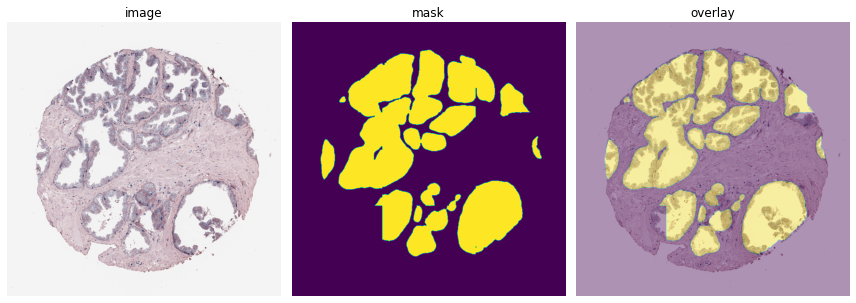

In [9]:
if debug:
    for img_id, mask in zip(imgs, pd_mks):
        img = cv2.imread(os.path.join(DATA, img_id+'.tiff'))
        plt.figure(figsize=(12, 7))
        plt.subplot(1, 3, 1); plt.imshow(img); plt.axis('OFF'); plt.title('image')
        plt.subplot(1, 3, 2); plt.imshow(mask*255); plt.axis('OFF'); plt.title('mask')
        plt.subplot(1, 3, 3); plt.imshow(img); plt.imshow(mask*255, alpha=0.4); plt.axis('OFF'); plt.title('overlay')
        plt.tight_layout()
        plt.show()